<a href="https://colab.research.google.com/github/andy258741/Final_final_project/blob/master/7112029030_w2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 先獲取台積的整年交易資料

In [26]:
import requests
import pandas as pd
from datetime import datetime

# 將民國年轉換為西元年
def convert_date(date_str):
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)  # 民國年轉西元年
    return f"{year}/{month}/{day}"

def fetch_monthly_data(stock_no, year, month):
    # 定義日期，使用每月的第一天作為請求參數
    date_str = f"{year}{month:02d}01"
    url = f"https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date_str}&stockNo={stock_no}"

    # 發送 API 請求
    response = requests.get(url)

    # 如果請求成功，返回JSON數據
    if response.status_code == 200:
        return response.json()
    else:
        return None

def fetch_yearly_data(stock_no, year):
    all_data = []

    for month in range(1, 13):  # 從1月到12月
        data = fetch_monthly_data(stock_no, year, month)
        if data and data['stat'] == 'OK':
            # 將每個月的數據添加到列表中
            all_data.extend(data['data'])

    # 將數據轉換為DataFrame，並指定欄位名稱
    df = pd.DataFrame(all_data, columns=["日期", "成交股數", "成交金額", "開盤價", "最高價", "最低價", "收盤價", "漲跌價差", "成交筆數"])

    # 全部換成float以利後續計算
    # 使用 applymap 將 replace 和 astype 應用於每個單元格
    for col in ["成交股數", "成交金額", "開盤價", "最高價", "最低價", "收盤價", "成交筆數"]:
        df[col] = df[col].astype(str).str.replace(",", "").astype(float)

    # 將日期從民國年轉換為西元年格式
    df['日期'] = df['日期'].apply(convert_date)

    # 將日期欄位轉換為datetime格式，並重新排序數據
    df['日期'] = pd.to_datetime(df['日期'], format='%Y/%m/%d')
    df = df.sort_values(by='日期').reset_index(drop=True)

    return df

# 範例查詢：查詢台積電 (2330) 在 2023 年的收盤價
stock_no = '2330'
year = 2024

# 獲取一整年的數據
df = fetch_yearly_data(stock_no, year)

# 查看台積一整年每日交易資料
df


,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
0,2024-01-02,27997826.0,1.654962e+10,590.0,593.0,589.0,593.0,0.00,20667.0
1,2024-01-03,40134497.0,2.326703e+10,584.0,585.0,576.0,578.0,-15.00,56916.0
2,2024-01-04,18063758.0,1.046628e+10,580.0,581.0,577.0,580.0,+2.00,15010.0
3,2024-01-05,22008878.0,1.268546e+10,578.0,580.0,574.0,576.0,-4.00,28660.0
4,2024-01-08,19270119.0,1.123294e+10,582.0,585.0,579.0,583.0,+7.00,19950.0
...,...,...,...,...,...,...,...,...,...
175,2024-09-24,29324170.0,2.872681e+10,976.0,987.0,971.0,987.0,+10.00,63433.0
176,2024-09-25,43039991.0,4.305301e+10,1000.0,1005.0,998.0,1005.0,+18.00,82005.0
177,2024-09-26,43341810.0,4.383552e+10,1010.0,1015.0,1005.0,1015.0,+10.00,78670.0
178,2024-09-27,37665070.0,3.807497e+10,1020.0,1025.0,1000.0,1000.0,-15.00,52093.0


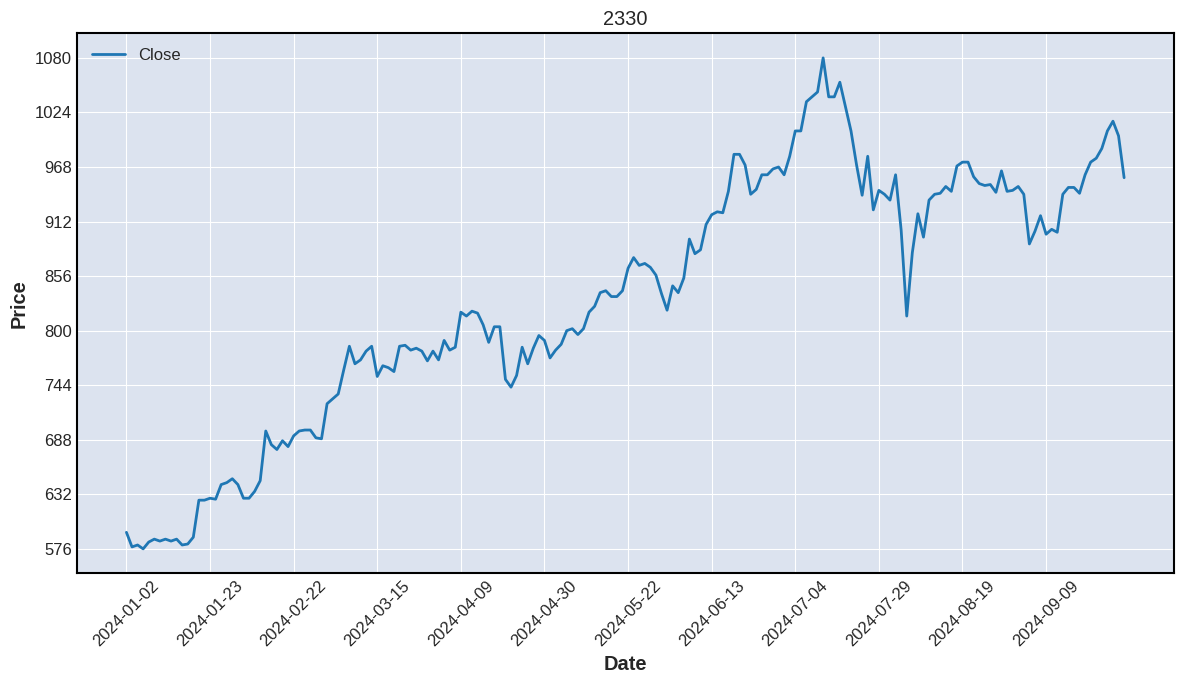

In [29]:
# 2330收盤價可視化
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for linspace

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
plt.plot(df['收盤價'], label='Close')

# 設定 x 軸的時間
num = 12
date = df["日期"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num],
           rotation=45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title('2330')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)

# 設定 y 軸刻度，平均間隔顯示十個數字
# Get the minimum and maximum values of the '收盤價' column
ymin = df['收盤價'].min()
ymax = df['收盤價'].max()

# Generate 10 evenly spaced values between ymin and ymax
yticks = np.linspace(ymin, ymax, 10)
# Set the y-axis ticks to the generated values
plt.yticks(yticks)

plt.tight_layout()

# 顯示圖表
plt.show()

# 1. SMA, RSI, MACD

In [30]:
# 拿取每日收盤價
close_prices = df['收盤價'].astype(float)

In [31]:
# SMA
import pandas as pd
def calculate_sma(data, window):
  return close_prices.rolling(window=window).mean()

# 假設 df 是包含每日收盤價的 DataFrame
df['SMA_20'] = calculate_sma(df, window=20)  # 20日SMA
df['SMA_14'] = calculate_sma(df, window=14)  # 14日SMA
df['SMA_7'] = calculate_sma(df, window=7)  # 7日SMA

In [32]:
# RSI
def calculate_rsi(data, window=14):
  delta = close_prices.diff(1)  # 計算每日價格變動
  gain = delta.where(delta > 0, 0)  # 計算漲幅
  loss = -delta.where(delta < 0, 0)  # 計算跌幅

  avg_gain = gain.rolling(window=window).mean()  # 平均漲幅
  avg_loss = loss.rolling(window=window).mean()  # 平均跌幅

  rs = avg_gain / avg_loss  # 計算 RS
  rsi = 100 - (100 / (1 + rs))  # 計算 RSI

  return rsi

df['RSI_14'] = calculate_rsi(df)


In [33]:
# MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
  short_ema = close_prices.ewm(span=short_window, adjust=False).mean()  # 短期EMA
  long_ema = close_prices.ewm(span=long_window, adjust=False).mean()  # 長期EMA
  macd = short_ema - long_ema  # 計算MACD線
  signal = macd.ewm(span=signal_window, adjust=False).mean()  # 計算信號線
  histogram = macd - signal  # 計算柱狀圖

  return macd, signal, histogram

df['MACD'], df['Signal_Line'], df['MACD_Histogram'] = calculate_macd(df)

In [34]:
# 查看df
df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,SMA_20,SMA_14,SMA_7,RSI_14,MACD,Signal_Line,MACD_Histogram
0,2024-01-02,27997826.0,1.654962e+10,590.0,593.0,589.0,593.0,0.00,20667.0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2024-01-03,40134497.0,2.326703e+10,584.0,585.0,576.0,578.0,-15.00,56916.0,NaN,NaN,NaN,NaN,-1.196581,-0.239316,-0.957265
2,2024-01-04,18063758.0,1.046628e+10,580.0,581.0,577.0,580.0,+2.00,15010.0,NaN,NaN,NaN,NaN,-1.960893,-0.583632,-1.377262
3,2024-01-05,22008878.0,1.268546e+10,578.0,580.0,574.0,576.0,-4.00,28660.0,NaN,NaN,NaN,NaN,-2.856455,-1.038196,-1.818259
4,2024-01-08,19270119.0,1.123294e+10,582.0,585.0,579.0,583.0,+7.00,19950.0,NaN,NaN,NaN,NaN,-2.967149,-1.423987,-1.543162


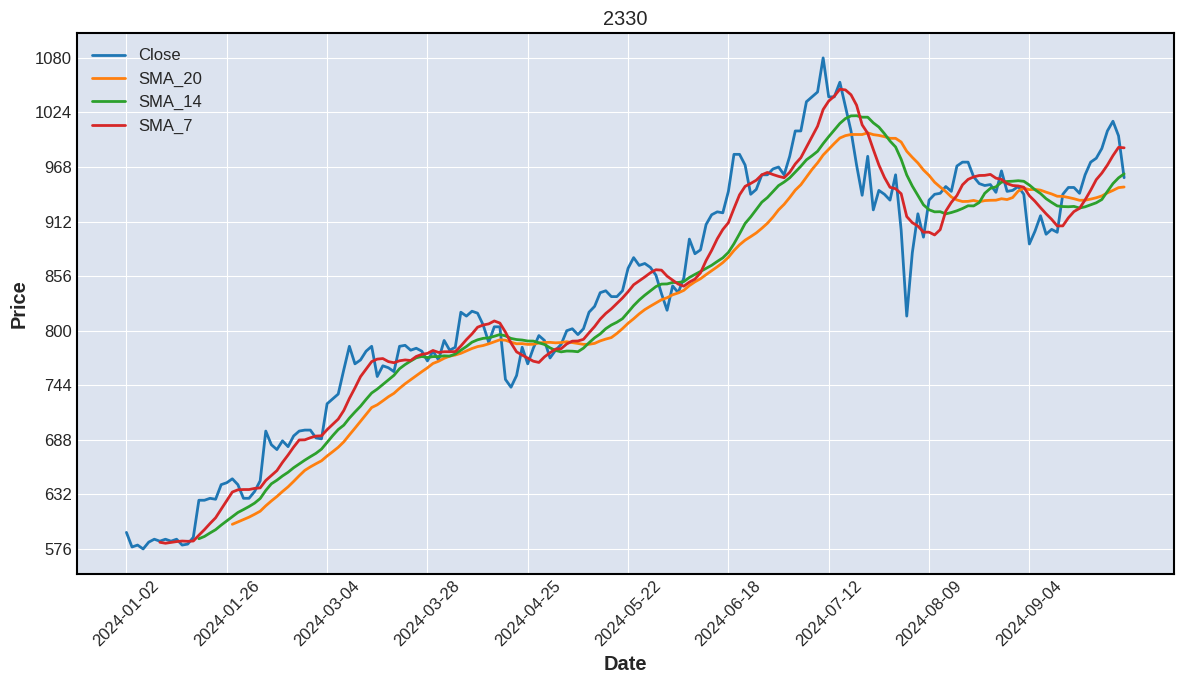

In [35]:
# 2330 收盤價,SMA可視化
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for linspace

# 畫布尺寸大小設定
plt.figure(figsize=(12, 7))

# 設定要繪製的資料欄位
# Convert '收盤價' column to numeric, errors='coerce' handles non-numeric values
df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')
plt.plot(df['收盤價'], label='Close')
plt.plot(df['SMA_20'], label='SMA_20')
plt.plot(df['SMA_14'], label='SMA_14')
plt.plot(df['SMA_7'], label='SMA_7')

# 設定 x 軸的時間
num = 10
date = df["日期"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num],
           rotation=45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title('2330')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid(True)

# 設定 y 軸刻度，平均間隔顯示十個數字
# Get the minimum and maximum values of the '收盤價' column
ymin = df['收盤價'].min()
ymax = df['收盤價'].max()
# Generate 10 evenly spaced values between ymin and ymax
yticks = np.linspace(ymin, ymax, 10)
# Set the y-axis ticks to the generated values
plt.yticks(yticks)

plt.tight_layout()

# 顯示圖表
plt.show()

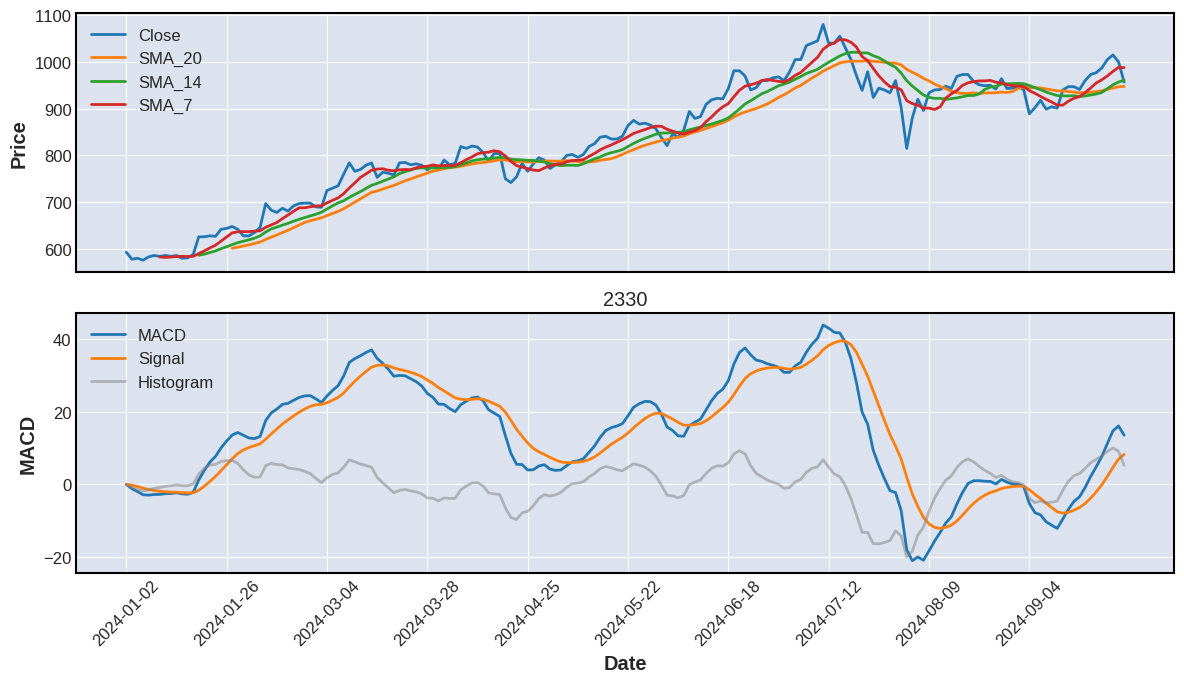

In [36]:
# 2330 其他指標可視化
import matplotlib.pyplot as plt
import numpy as np  # Import numpy for linspace
import pandas as pd

# 畫布尺寸大小設定
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 7), sharex=True)  # Create two subplots

# Convert '收盤價' column to numeric, errors='coerce' handles non-numeric values
df['收盤價'] = pd.to_numeric(df['收盤價'], errors='coerce')

# Plot Close Price and SMA_20 on the first subplot (ax1)
ax1.plot(df['收盤價'], label='Close')
ax1.plot(df['SMA_20'], label='SMA_20')
ax1.plot(df['SMA_14'], label='SMA_14')
ax1.plot(df['SMA_7'], label='SMA_7')
ax1.set_ylabel('Price')  # Set y-axis label for the first subplot
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot MACD on the second subplot (ax2)
ax2.plot(df['MACD'], label='MACD')
ax2.plot(df['Signal_Line'], label='Signal')
ax2.plot(df['MACD_Histogram'], label='Histogram', color='gray', alpha=0.5)  # Optional: Plot histogram
ax2.set_ylabel('MACD')  # Set y-axis label for the second subplot
ax2.legend(loc='upper left')  # Call legend after adding all lines
ax2.grid(True)



# 設定 x 軸的時間
num = 10
date = df["日期"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num],
           rotation=45)


# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title('2330')
plt.xlabel('Date')
# plt.ylabel('Price')


plt.tight_layout()

# 顯示圖表
plt.show()

# 2. K線圖

In [37]:
!pip install mplfinance

In [38]:
df.head()

,日期,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,SMA_20,SMA_14,SMA_7,RSI_14,MACD,Signal_Line,MACD_Histogram
0,2024-01-02,27997826.0,1.654962e+10,590.0,593.0,589.0,593.0,0.00,20667.0,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
1,2024-01-03,40134497.0,2.326703e+10,584.0,585.0,576.0,578.0,-15.00,56916.0,NaN,NaN,NaN,NaN,-1.196581,-0.239316,-0.957265
2,2024-01-04,18063758.0,1.046628e+10,580.0,581.0,577.0,580.0,+2.00,15010.0,NaN,NaN,NaN,NaN,-1.960893,-0.583632,-1.377262
3,2024-01-05,22008878.0,1.268546e+10,578.0,580.0,574.0,576.0,-4.00,28660.0,NaN,NaN,NaN,NaN,-2.856455,-1.038196,-1.818259
4,2024-01-08,19270119.0,1.123294e+10,582.0,585.0,579.0,583.0,+7.00,19950.0,NaN,NaN,NaN,NaN,-2.967149,-1.423987,-1.543162


In [40]:
# 複製df並重新命名欄位

# 提取需要的欄位
df_mpl = df[['日期', '成交股數', '開盤價', '最高價', '最低價', '收盤價', 'SMA_20', 'RSI_14', 'MACD', 'Signal_Line', 'MACD_Histogram']]

# 重命名列以符合 mplfinance 的要求
df_mpl.columns = ['Date', 'Volume', 'Open', 'High', 'Low', 'Close', 'SMA_20', 'RSI_14', 'MACD', 'Signal_Line', 'MACD_Histogram']

# 確保日期列作為索引，並轉換為 datetime 格式（如尚未完成）
df_mpl['Date'] = pd.to_datetime(df_mpl['Date'])
df_mpl.set_index('Date', inplace=True)

# 顯示處理後的 DataFrame
print(df_mpl.head())


                Volume   Open   High    Low  Close  SMA_20  RSI_14      MACD  \
Date                                                                           
2024-01-02  27997826.0  590.0  593.0  589.0  593.0     NaN     NaN  0.000000   
2024-01-03  40134497.0  584.0  585.0  576.0  578.0     NaN     NaN -1.196581   
2024-01-04  18063758.0  580.0  581.0  577.0  580.0     NaN     NaN -1.960893   
2024-01-05  22008878.0  578.0  580.0  574.0  576.0     NaN     NaN -2.856455   
2024-01-08  19270119.0  582.0  585.0  579.0  583.0     NaN     NaN -2.967149   

            Signal_Line  MACD_Histogram  
Date                                     
2024-01-02     0.000000        0.000000  
2024-01-03    -0.239316       -0.957265  
2024-01-04    -0.583632       -1.377262  
2024-01-05    -1.038196       -1.818259  
2024-01-08    -1.423987       -1.543162  


<ipython-input-40-eeff587bf248>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mpl['Date'] = pd.to_datetime(df_mpl['Date'])


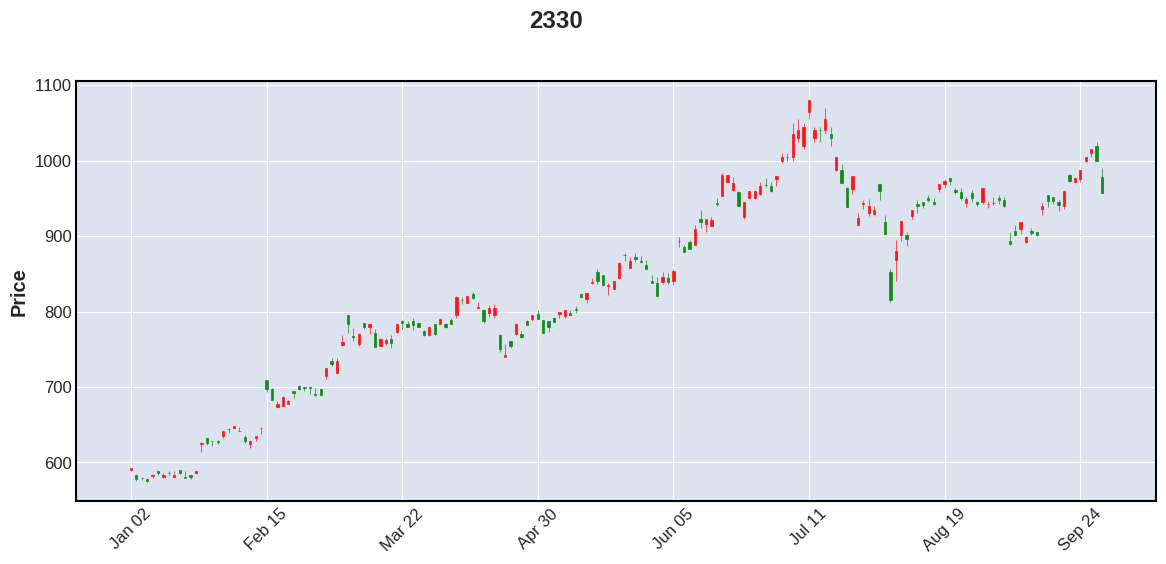

In [41]:
import mplfinance as mpf
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)

# 使用 mplfinance 繪製 K 線圖
mpf.plot(df_mpl, type='candle', style=my_style, title='2330', figsize=(15, 6))



# 3. 技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

In [42]:
import numpy as np  # 引入 numpy，用於數據處理和數值運算
from sklearn.model_selection import train_test_split  # 引入 train_test_split，用於將數據集拆分為訓練集和測試集
from sklearn.metrics import mean_squared_error  # 引入 mean_squared_error 用於評估模型性能

In [43]:
# 標籤生成: 預測未來1天的價格
n = 1
df['Future_Price'] = df['收盤價'].shift(-n)

# 去除缺失值
df.dropna(inplace=True)

# 使用特徵
X = df[['SMA_20', 'RSI_14', 'MACD', 'Signal_Line', 'MACD_Histogram']]

# 標籤（未來價格）
y = df['Future_Price']

X.shape, y.shape

((160, 5), (160,))

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 查看拆分後訓練集和測試集的形狀
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((128, 5), (32, 5), (128,), (32,))

# 線性回歸(LinearRegression)

In [45]:
# 引入線性回歸模型
from sklearn.linear_model import LinearRegression

# 建立並訓練線性回歸模型
model = LinearRegression()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"線性回歸模型RMSE: {rmse:.2f}")

# 使用模型進行未來價格走勢預測
future_pred = model.predict(X[-1:])  # 使用最新的數據進行預測
print(f"線性回歸模型預測未來{n}天的價格: {future_pred[0]:.2f}")

線性回歸模型RMSE: 23.25
線性回歸模型預測未來1天的價格: 1021.42


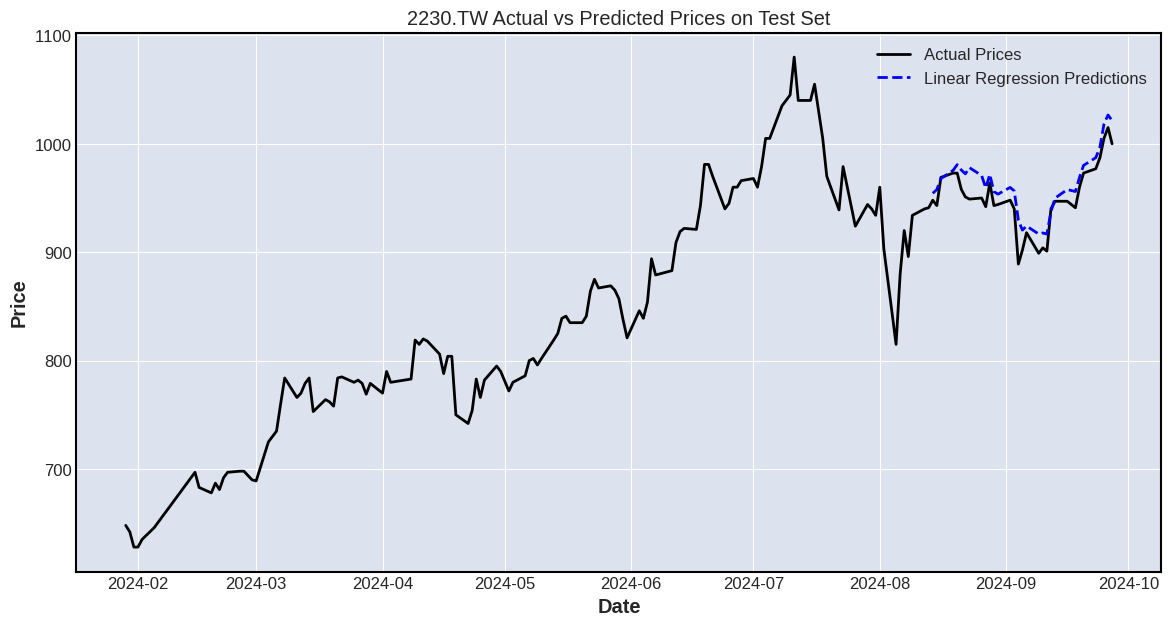

In [47]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['日期'], df['收盤價'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['日期'][-len(y_test):], y_pred, label='Linear Regression Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# 決策樹(DecisionTreeRegressor)

In [58]:
# 引入決策樹模型
from sklearn.tree import DecisionTreeRegressor

# 建立並訓練決策樹模型
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"線性回歸模型RMSE: {rmse:.2f}")

# 使用模型進行未來價格走勢預測
future_pred = model.predict(X[-1:])  # 使用最新的數據進行預測
print(f"線性回歸模型預測未來{n}天的價格: {future_pred[0]:.2f}")

線性回歸模型RMSE: 47.53
線性回歸模型預測未來1天的價格: 919.00


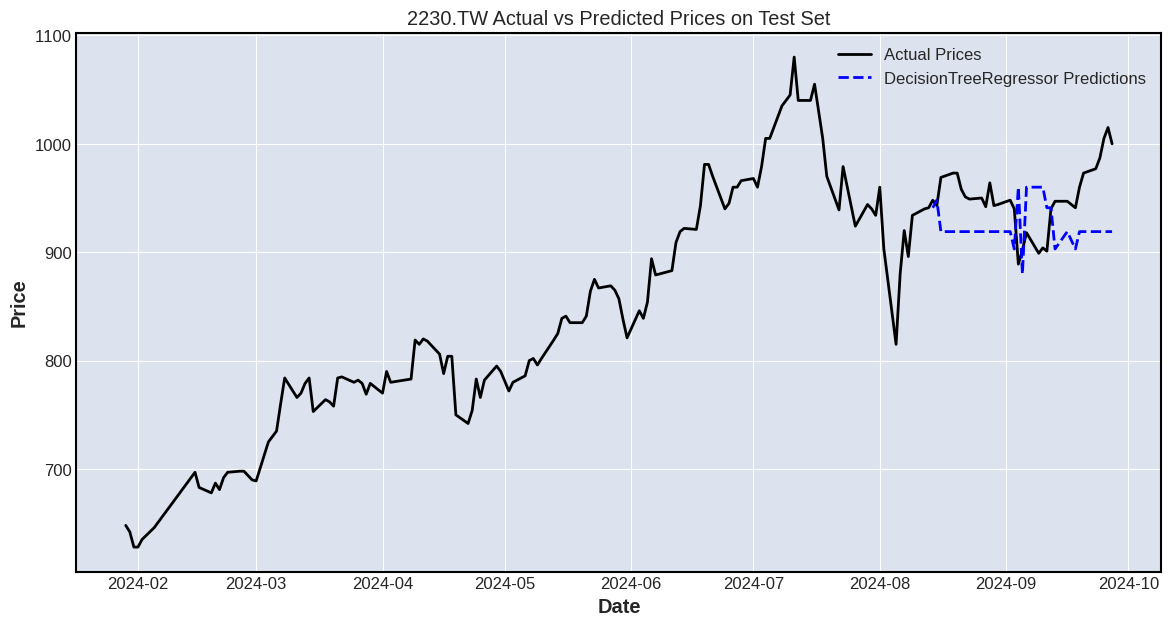

In [59]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['日期'], df['收盤價'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['日期'][-len(y_test):], y_pred, label='DecisionTreeRegressor Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# 隨機森林(RandomForestRegressor)

In [60]:
# 引入隨機森林模型
from sklearn.ensemble import RandomForestRegressor

# 建立並訓練隨機森林模型
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"隨機森林模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"隨機森林模型預測未來{n}天的價格: {future_pred[0]:.2f}")

隨機森林模型RMSE: 37.15
隨機森林模型預測未來1天的價格: 931.24


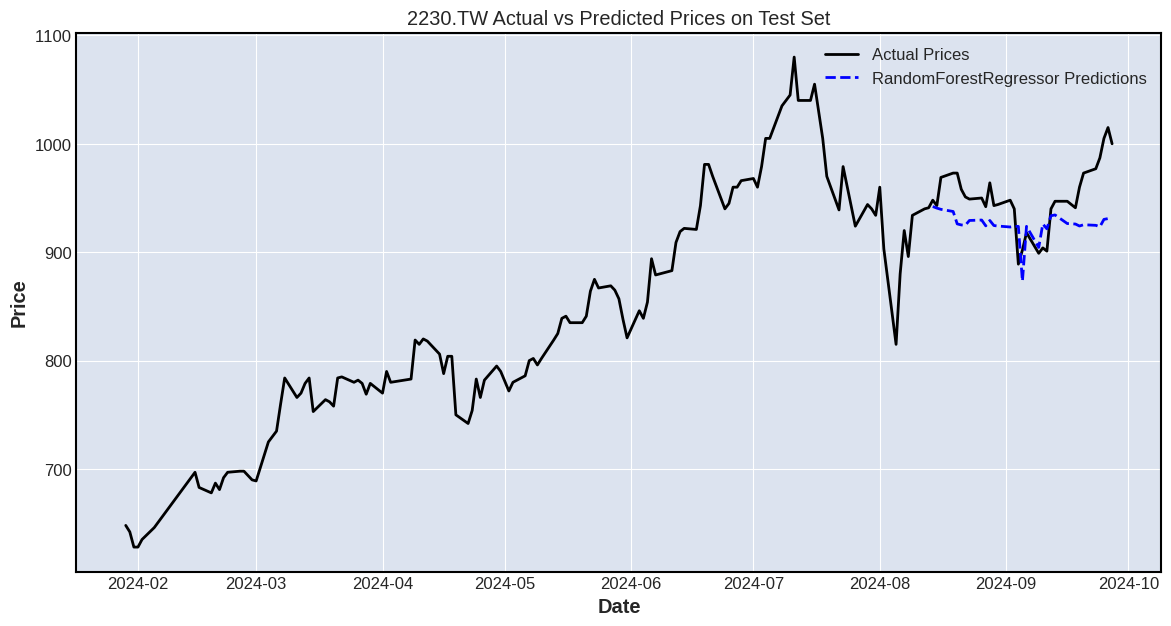

In [61]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['日期'], df['收盤價'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['日期'][-len(y_test):], y_pred, label='RandomForestRegressor Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# XGboost

In [64]:
# 引入XGboost模型
import xgboost as xgb

# 建立並訓練XGboost模型
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"XGboost模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"XGboost模型預測未來{n}天的價格: {future_pred[0]:.2f}")

XGboost模型RMSE: 29.71
XGboost模型預測未來1天的價格: 956.70


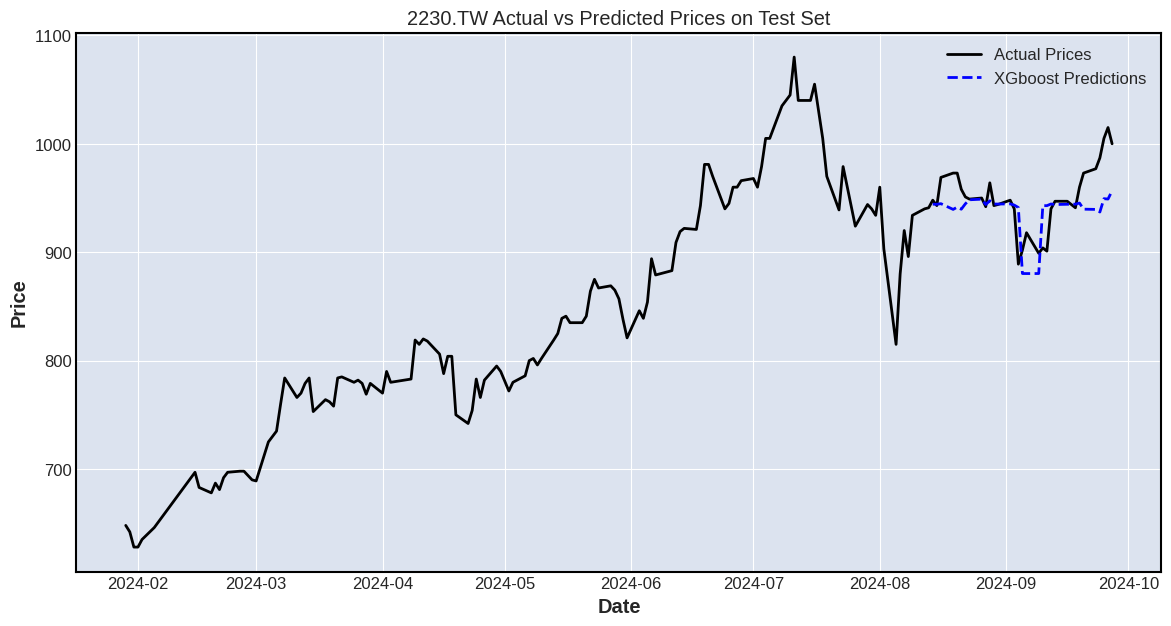

In [65]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['日期'], df['收盤價'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['日期'][-len(y_test):], y_pred, label='XGboost Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()

# Lightgbm

In [66]:
# 引入XGboost模型
import lightgbm as lgb

# 建立並訓練XGboost模型
model = lgb.LGBMRegressor(verbose=-1)
model.fit(X_train, y_train)

# 預測
y_pred = model.predict(X_test)

# 評估
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"lightgbm模型RMSE: {rmse:.2f}")

future_pred = model.predict(X[-1:])
print(f"lightgbm模型預測未來{n}天的價格: {future_pred[0]:.2f}")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


lightgbm模型RMSE: 29.64
lightgbm模型預測未來1天的價格: 940.01


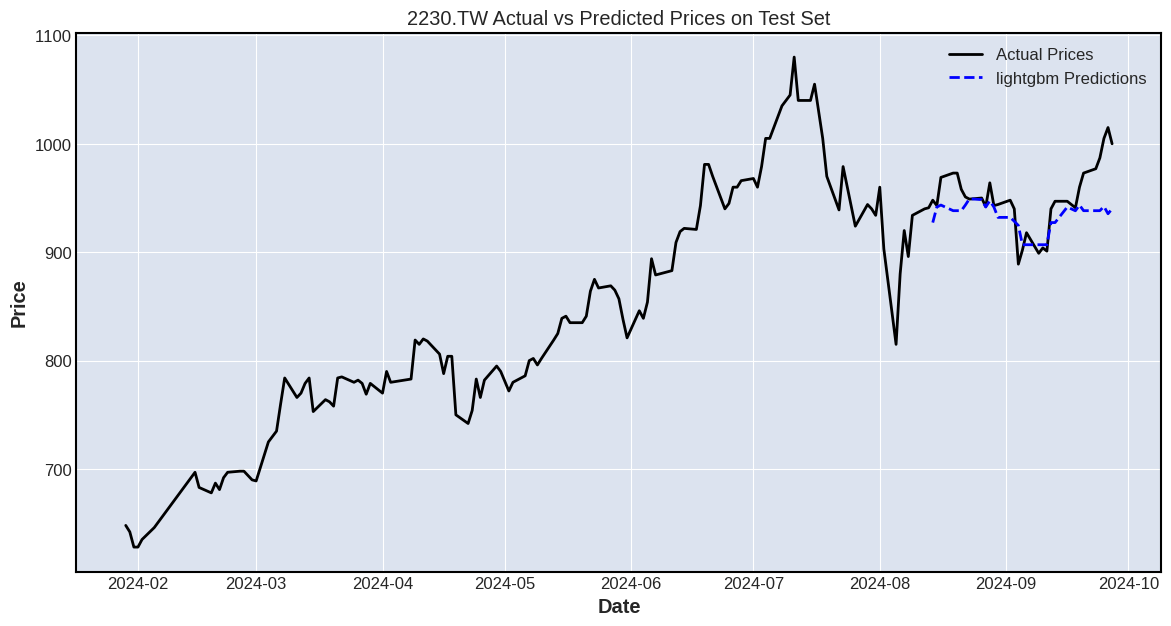

In [67]:
# 畫出測試集的實際價格與預測價格走勢圖
plt.figure(figsize=(14, 7))
plt.plot(df['日期'], df['收盤價'], label='Actual Prices', color='black', linewidth=2)
plt.plot(df['日期'][-len(y_test):], y_pred, label='lightgbm Predictions', linestyle='--', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('2230.TW Actual vs Predicted Prices on Test Set')
plt.legend()
plt.grid(True)
plt.show()